In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import datasets
from sklearn import manifold
from torchvision import transforms

from utils.utils import dataset_loader

In [7]:
# load dataset
eval_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((448, 448)),
    transforms.ToTensor()

    ])

transformation = transforms.Compose([transforms.ToTensor()])

train_dataset, test_dataset,train_loader, test_loader,classes = dataset_loader('ck',165,transformation,eval_transforms)
print(len(test_dataset))

165


In [8]:
tsne = manifold.TSNE(n_components=2)
for image,_,label in test_loader:
    #image = image
    image = image.reshape(image.shape[0], -1)
    label = label

In [9]:
tsne_np = tsne.fit_transform(image)

In [10]:
# create dataframe
cps_df = pd.DataFrame(columns=['CP1', 'CP2', 'target'],
                       data=np.column_stack((tsne_np,
                                            label)))
# cast targets column to int
cps_df.loc[:, 'target'] = cps_df.target.astype(int)
cps_df.head()

,CP1,CP2,target
0,-5.849614,-13.644562,5
1,3.681832,10.075545,6
2,2.584228,-10.355353,0
3,2.085568,12.345162,0
4,5.592676,-9.149228,3


In [11]:
classes_map = {i : classes[i] for i in range(len(classes))}
# map targets to actual clothes for plotting
cps_df.loc[:, 'target'] = cps_df.target.map(classes_map)

<Axes: >

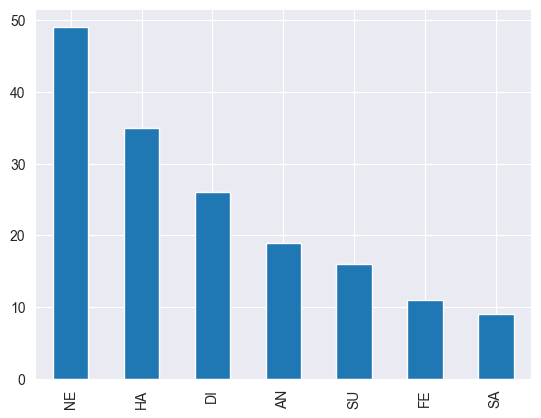

In [12]:
cps_df.target.value_counts().plot(kind='bar')

C:\Users\User\anaconda3\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


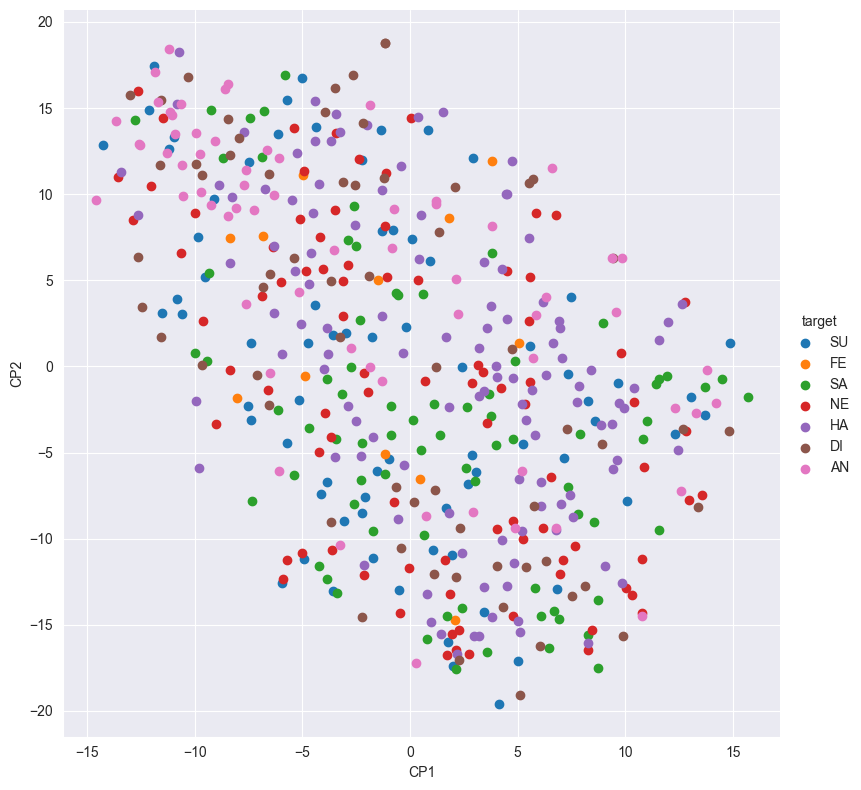

In [9]:
grid = sns.FacetGrid(cps_df, hue="target", height=8)
grid.map(plt.scatter, 'CP1', 'CP2').add_legend()

In [3]:
# pytorch
import torch
import torchvision
from torchvision import transforms, datasets, models
from torchsummary import summary

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# other
import numpy as np
import matplotlib.pyplot as plt
import copy
import time

In [4]:
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()

    def forward(self, x):
        return x

In [5]:
resnet_pt = models.resnet50(pretrained=True)
fc_in_features = resnet_pt.fc.in_features
resnet_pt.fc = Identity()
resnet_pt = resnet_pt.to(device)

C:\Users\User\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
summary(resnet_pt, (3,448,448))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           9,408
       BatchNorm2d-2         [-1, 64, 224, 224]             128
              ReLU-3         [-1, 64, 224, 224]               0
         MaxPool2d-4         [-1, 64, 112, 112]               0
            Conv2d-5         [-1, 64, 112, 112]           4,096
       BatchNorm2d-6         [-1, 64, 112, 112]             128
              ReLU-7         [-1, 64, 112, 112]               0
            Conv2d-8         [-1, 64, 112, 112]          36,864
       BatchNorm2d-9         [-1, 64, 112, 112]             128
             ReLU-10         [-1, 64, 112, 112]               0
           Conv2d-11        [-1, 256, 112, 112]          16,384
      BatchNorm2d-12        [-1, 256, 112, 112]             512
           Conv2d-13        [-1, 256, 112, 112]          16,384
      BatchNorm2d-14        [-1, 256, 1

In [10]:
actual = []
deep_features = []

resnet_pt.eval()
with torch.no_grad():
    for image,_,label in test_loader:
        images, labels = image.to(device), label.to(device)
        features = resnet_pt(images)

        deep_features += features.cpu().numpy().tolist()
        actual += labels.cpu().numpy().tolist()

cluster = np.array(tsne.fit_transform(np.array(deep_features)))
actual = np.array(actual)

In [11]:
# create dataframe
cps_df = pd.DataFrame(columns=['CP1', 'CP2', 'target'],
                       data=np.column_stack((cluster,
                                            actual)))
# cast targets column to int
cps_df.loc[:, 'target'] = cps_df.target.astype(int)
cps_df.head()

,CP1,CP2,target
0,-7.372662,12.900290,4
1,-51.271164,-17.423294,0
2,17.388296,18.896915,3
3,-13.383821,-10.210391,0
4,-44.354660,13.354593,4


In [12]:
classes_map = {i : classes[i] for i in range(len(classes))}
# map targets to actual clothes for plotting
cps_df.loc[:, 'target'] = cps_df.target.map(classes_map)

<Axes: >

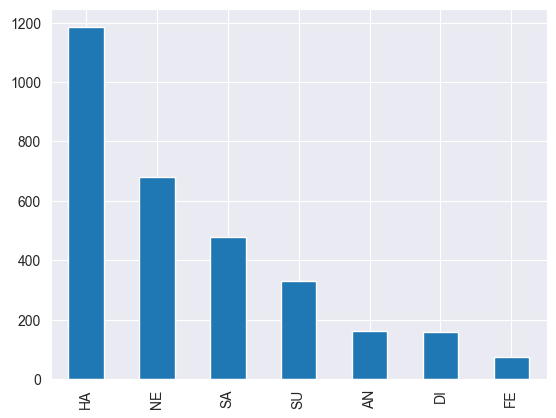

In [13]:
cps_df.target.value_counts().plot(kind='bar')

C:\Users\User\anaconda3\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


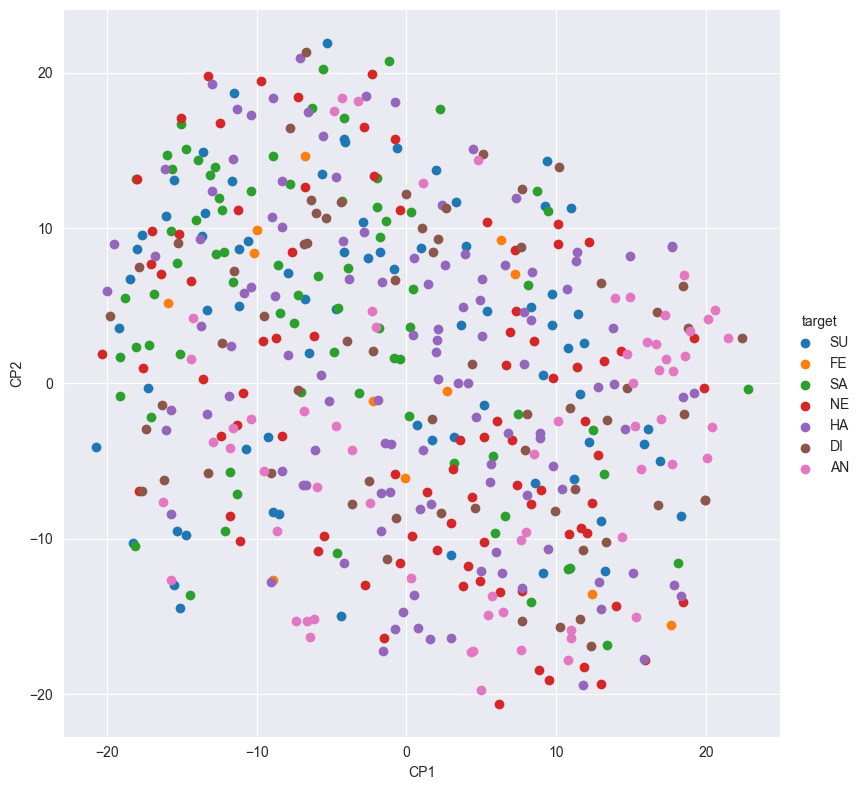

In [12]:
grid = sns.FacetGrid(cps_df, hue="target", height=8)
grid.map(plt.scatter, 'CP1', 'CP2').add_legend()

In [13]:
from models.transformNetwork448 import init_weights,Network,Bottleneck
model = Network(Bottleneck, [3, 4, 6, 3],parallel=[0.9,0.7,0.5], num_layers=3).to(device)
model.eval()
model.load_state_dict(torch.load("D:/github/CLFW/weights/train_raf_scale_0.9_acc_tensor(0.8734, device='cuda_0', dtype=torch.float64).pt"))

actual_mine = []
deep_features_mine = []

with torch.no_grad():
    for image,_,label in test_loader:

        images, labels = image.to(device), label.to(device)
        features,out = model(images)

        reshape_feature = features.reshape(features.shape[0],-1)

        deep_features_mine += reshape_feature.cpu().numpy().tolist()
        actual_mine += labels.cpu().numpy().tolist()


In [14]:
#deep_features_mine_new=np.array(deep_features_mine).reshape(np.array(deep_features_mine).shape[0], np.array(deep_features_mine).shape[1],-1)
cluster = np.array(tsne.fit_transform(np.array(deep_features_mine)))
actual = np.array(actual_mine)

In [15]:
# create dataframe
cps_df = pd.DataFrame(columns=['CP1', 'CP2', 'target'],
                       data=np.column_stack((cluster,
                                            actual)))
# cast targets column to int
cps_df.loc[:, 'target'] = cps_df.target.astype(int)
cps_df.head()

,CP1,CP2,target
0,-0.987449,0.086247,0
1,-0.689494,1.902130,1
2,-0.396457,-0.499915,4
3,-1.575306,-4.773088,6
4,2.931743,1.626725,3


In [16]:
classes_map = {i : classes[i] for i in range(len(classes))}
# map targets to actual clothes for plotting
cps_df.loc[:, 'target'] = cps_df.target.map(classes_map)

<Axes: >

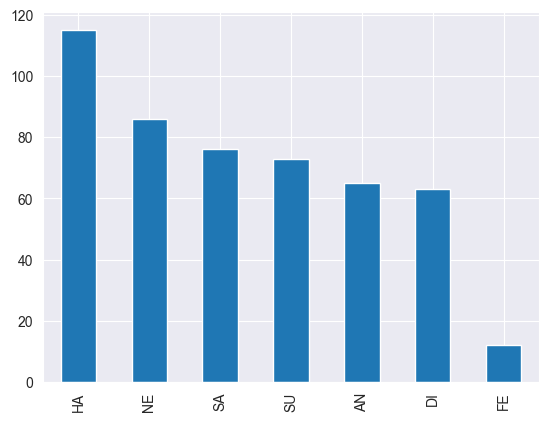

In [17]:
cps_df.target.value_counts().plot(kind='bar')

C:\Users\User\anaconda3\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


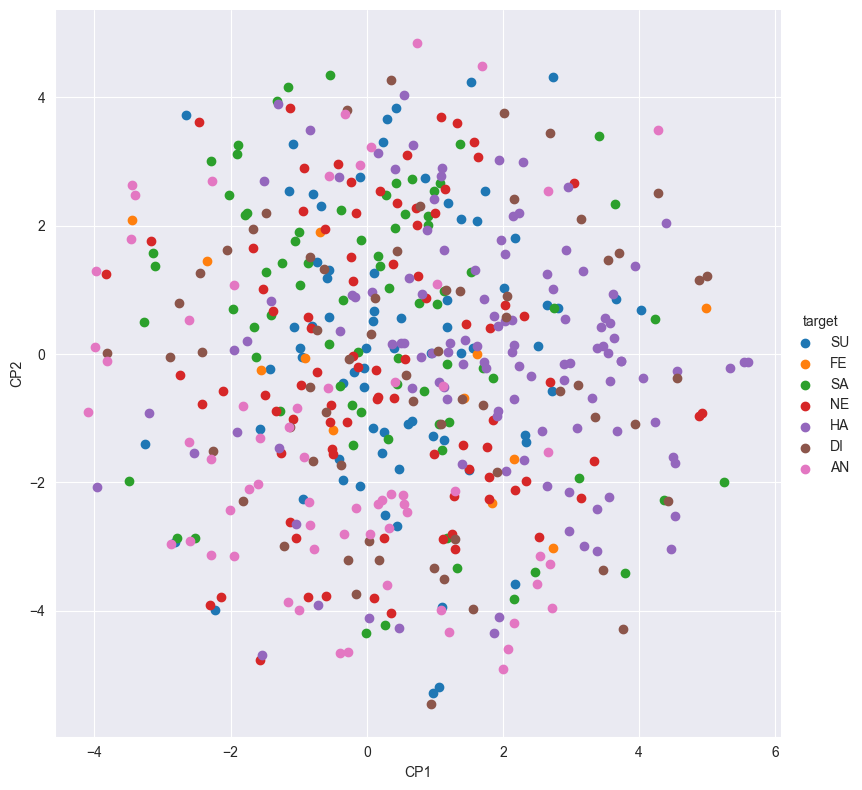

In [18]:
grid = sns.FacetGrid(cps_df, hue="target", height=8)
grid.map(plt.scatter, 'CP1', 'CP2').add_legend()